In [1]:
# visualisation
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from scipy import ndimage
from PIL import Image
import random

# GroundingDINO
import groundingdino.datasets.transforms as T
from groundingdino.util import box_ops
from groundingdino.util.inference import annotate, predict, load_model

# SAM
from segment_anything import build_sam, SamPredictor 
# import cv2

# clipseg
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

c:\Users\LHaiHui\AppData\Local\anaconda3\envs\grounding_sam_cpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load models
def loadGroundingDINO(ckpt_config, ckpt_file, device):
    dino_model = load_model(ckpt_config, ckpt_file, device)
    print("GroundingDINO loaded.")
    return dino_model

def loadSAM(sam_ckpt, device):
    sam = build_sam(checkpoint=sam_ckpt)
    sam.to(device=device)
    sam_predictor = SamPredictor(sam)
    print("SAM loaded.")
    return sam_predictor

def loadCLIPSeg():
  clipseg_processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
  clipseg_model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")
  print("CLIPSeg loaded.")
  return clipseg_processor, clipseg_model

In [3]:
# helper methods
def load_image_for_dino(image):
    transform = T.Compose(
        [
            T.RandomResize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    dino_image, _ = transform(image, None)
    return dino_image

def dino_detection(
    model,
    image,
    image_array,
    category_names,
    category_names_to_id,
    box_threshold,
    text_threshold,
    device,
    visualize=False,
):
    detection_prompt = " . ".join(category_names)
    dino_image = load_image_for_dino(image)
    dino_image = dino_image.to(device)
    with torch.no_grad():
        boxes, logits, phrases = predict(
            model=model,
            image=dino_image,
            caption=detection_prompt,
            box_threshold=box_threshold,
            text_threshold=text_threshold,
            device=device,
        )
    category_ids = [category_names_to_id[phrase] for phrase in phrases]

    if visualize:
        annotated_frame = annotate(
            image_source=image_array, boxes=boxes, logits=logits, phrases=phrases
        )
        annotated_frame = annotated_frame[..., ::-1]  # BGR to RGB
        visualization = Image.fromarray(annotated_frame)
        return boxes, category_ids, visualization
    else:
        return boxes, category_ids, phrases

def sam_masks_from_dino_boxes(predictor, image_array, boxes, device):
    # box: normalized box xywh -> unnormalized xyxy
    H, W, _ = image_array.shape
    boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])
    transformed_boxes = predictor.transform.apply_boxes_torch(
        boxes_xyxy, image_array.shape[:2]
    ).to(device)
    thing_masks, _, _ = predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=transformed_boxes,
        multimask_output=False,
    )
    return thing_masks

def preds_to_semantic_inds(preds, threshold):
    flat_preds = preds.reshape((preds.shape[0], -1))
    # Initialize a dummy "unlabeled" mask with the threshold
    flat_preds_with_treshold = torch.full(
        (preds.shape[0] + 1, flat_preds.shape[-1]), threshold
    )
    flat_preds_with_treshold[1 : preds.shape[0] + 1, :] = flat_preds

    # Get the top mask index for each pixel
    semantic_inds = torch.topk(flat_preds_with_treshold, 1, dim=0).indices.reshape(
        (preds.shape[-2], preds.shape[-1])
    )

    return semantic_inds

def clipseg_segmentation(
    processor, model, image, category_names, background_threshold, device
):
    inputs = processor(
        text=category_names,
        images=[image] * len(category_names),
        padding="max_length",
        return_tensors="pt",
    ).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    if len(logits.shape) == 2:
      logits = logits.unsqueeze(0)
    # resize the outputs
    upscaled_logits = nn.functional.interpolate(
        logits.unsqueeze(1),
        size=(image.size[1], image.size[0]),
        mode="bilinear",
    )
    preds = torch.sigmoid(upscaled_logits.squeeze(dim=1))
    semantic_inds = preds_to_semantic_inds(preds, background_threshold)
    return preds, semantic_inds

def semantic_inds_to_shrunken_bool_masks(
    semantic_inds, shrink_kernel_size, num_categories
):
    shrink_kernel = np.ones((shrink_kernel_size, shrink_kernel_size))

    bool_masks = torch.zeros((num_categories, *semantic_inds.shape), dtype=bool)
    for category in range(num_categories):
        binary_mask = semantic_inds == category
        shrunken_binary_mask_array = (
            ndimage.binary_erosion(binary_mask.numpy(), structure=shrink_kernel)
            if shrink_kernel_size > 0
            else binary_mask.numpy()
        )
        bool_masks[category] = torch.from_numpy(shrunken_binary_mask_array)

    return bool_masks

def clip_and_shrink_preds(semantic_inds, preds, shrink_kernel_size, num_categories):
    # convert semantic_inds to shrunken bool masks
    bool_masks = semantic_inds_to_shrunken_bool_masks(
        semantic_inds, shrink_kernel_size, num_categories
    ).to(preds.device)

    sizes = [
        torch.sum(bool_masks[i].int()).item() for i in range(1, bool_masks.size(0))
    ]
    max_size = max(sizes)
    relative_sizes = [size / max_size for size in sizes] if max_size > 0 else sizes

    # use bool masks to clip preds
    clipped_preds = torch.zeros_like(preds)
    for i in range(1, bool_masks.size(0)):
        float_mask = bool_masks[i].float()
        clipped_preds[i - 1] = preds[i - 1] * float_mask

    return clipped_preds, relative_sizes

def sample_points_based_on_preds(preds, N):
    height, width = preds.shape
    weights = preds.ravel()
    indices = np.arange(height * width)

    # Randomly sample N indices based on the weights
    sampled_indices = random.choices(indices, weights=weights, k=N)

    # Convert the sampled indices into (col, row) coordinates
    sampled_points = [(index % width, index // width) for index in sampled_indices]

    return sampled_points

def upsample_pred(pred, image_source):
    pred = pred.unsqueeze(dim=0)
    original_height = image_source.shape[0]
    original_width = image_source.shape[1]

    larger_dim = max(original_height, original_width)
    aspect_ratio = original_height / original_width

    # upsample the tensor to the larger dimension
    upsampled_tensor = F.interpolate(
        pred, size=(larger_dim, larger_dim), mode="bilinear", align_corners=False
    )

    # remove the padding (at the end) to get the original image resolution
    if original_height > original_width:
        target_width = int(upsampled_tensor.shape[3] * aspect_ratio)
        upsampled_tensor = upsampled_tensor[:, :, :, :target_width]
    else:
        target_height = int(upsampled_tensor.shape[2] * aspect_ratio)
        upsampled_tensor = upsampled_tensor[:, :, :target_height, :]
    return upsampled_tensor.squeeze(dim=1)

def sam_mask_from_points(predictor, image_array, points):
    points_array = np.array(points)
    # we only sample positive points, so labels are all 1
    points_labels = np.ones(len(points))
    # we don't use predict_torch here cause it didn't seem to work...
    masks, scores, logits = predictor.predict(
        point_coords=points_array,
        point_labels=points_labels,
    )
    # max over the 3 segmentation levels
    total_pred = torch.max(torch.sigmoid(torch.tensor(logits)), dim=0)[0].unsqueeze(
        dim=0
    )
    # logits are 256x256 -> upsample back to image shape
    upsampled_pred = upsample_pred(total_pred, image_array)
    return upsampled_pred

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_segmentation_preds(preds, category_names):
    len_cats = len(category_names)
    _, ax = plt.subplots(1, len_cats + 1, figsize=(3 * (len_cats + 1), 4))
    [a.axis("off") for a in ax.flatten()]
    ax[0].imshow(image)
    [ax[i + 1].imshow(preds[i].cpu()) for i in range(len_cats)]
    [
        ax[i + 1].text(0, -15, category_name)
        for i, category_name in enumerate(category_names)
    ]

In [4]:
# main function
def generate_panoptic_mask(
    image,
    thing_categories,
    stuff_categories,
    category_names_to_id,
    dino_model,
    sam_predictor,
    clipseg_processor,
    clipseg_model,
    device,
    dino_box_threshold,
    dino_text_threshold,
    segmentation_background_threshold=0.1,
    shrink_kernel_size=20,
    num_samples_factor=1000,
):
    image = image.convert("RGB")
    image_array = np.asarray(image)

    # compute SAM image embedding
    sam_predictor.set_image(image_array)

    # detect boxes for "thing" categories using Grounding DINO
    thing_category_ids = []
    thing_masks = []
    thing_boxes = []
    if len(thing_categories) > 0:
        thing_boxes, thing_category_ids, _ = dino_detection(
            dino_model,
            image,
            image_array,
            thing_categories,
            category_names_to_id,
            dino_box_threshold,
            dino_text_threshold,
            device,
        )
        if len(thing_boxes) > 0:
            # get segmentation masks for the thing boxes
            thing_masks = sam_masks_from_dino_boxes(
                sam_predictor, image_array, thing_boxes, device
            )

    if len(stuff_categories) > 0:
        # get rough segmentation masks for "stuff" categories using CLIPSeg
        clipseg_preds, clipseg_semantic_inds = clipseg_segmentation(
            clipseg_processor,
            clipseg_model,
            image,
            stuff_categories,
            segmentation_background_threshold,
            device,
        )
        # remove things from stuff masks
        clipseg_semantic_inds_without_things = clipseg_semantic_inds.clone()
        if len(thing_boxes) > 0:
            combined_things_mask = torch.any(thing_masks, dim=0)
            clipseg_semantic_inds_without_things[combined_things_mask[0]] = 0
        # clip CLIPSeg preds based on non-overlapping semantic segmentation inds (+ optionally shrink the mask of each category)
        # also returns the relative size of each category
        clipsed_clipped_preds, relative_sizes = clip_and_shrink_preds(
            clipseg_semantic_inds_without_things,
            clipseg_preds,
            shrink_kernel_size,
            len(stuff_categories) + 1,
        )
        # get finer segmentation masks for the "stuff" categories using SAM
        sam_preds = torch.zeros_like(clipsed_clipped_preds)
        for i in range(clipsed_clipped_preds.shape[0]):
            clipseg_pred = clipsed_clipped_preds[i]
            # for each "stuff" category, sample points in the rough segmentation mask
            num_samples = int(relative_sizes[i] * num_samples_factor)
            if num_samples == 0:
                continue
            points = sample_points_based_on_preds(
                clipseg_pred.cpu().numpy(), num_samples
            )
            if len(points) == 0:
                continue
            # use SAM to get mask for points
            pred = sam_mask_from_points(sam_predictor, image_array, points)
            sam_preds[i] = pred
        sam_semantic_inds = preds_to_semantic_inds(
            sam_preds, segmentation_background_threshold
        )

    # combine the thing inds and the stuff inds into panoptic inds
    panoptic_inds = (
        sam_semantic_inds.clone()
        if len(stuff_categories) > 0
        else torch.zeros(image_array.shape[0], image_array.shape[1], dtype=torch.long)
    )
    ind = len(stuff_categories) + 1
    for thing_mask in thing_masks:
        # overlay thing mask on panoptic inds
        panoptic_inds[thing_mask.squeeze(dim=0)] = ind
        ind += 1

    return panoptic_inds, thing_category_ids

In [5]:
# define checkpoint and config paths
dino_ckpt_config = "../groundingdino/groundingdino/config/GroundingDINO_SwinT_OGC.py"
dino_ckpt_file = "../groundingdino/weights/groundingdino_swint_ogc.pth"
sam_ckpt = "../segment-anything/checkpoints/sam_vit_h_4b8939.pth"

# load models
device = "cpu" # or CUDA
dino_model = loadGroundingDINO(dino_ckpt_config, dino_ckpt_file, device)
sam_predictor = loadSAM(sam_ckpt, device)
clipseg_processor, clipseg_model = loadCLIPSeg()

c:\Users\LHaiHui\AppData\Local\anaconda3\envs\grounding_sam_cpu\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


GroundingDINO loaded.
SAM loaded.
CLIPSeg loaded.


Image '9909.png' loaded.


(-0.5, 1455.5, 1087.5, -0.5)

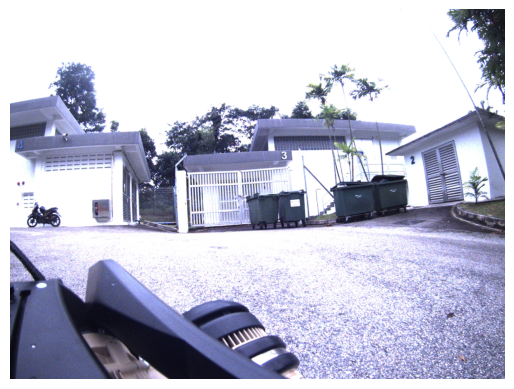

In [6]:
file = "9909"
image = Image.open("../images/" + file + ".png")
print("Image '" + file + ".png' loaded.")

image = image.convert("RGB")
image_array = np.asarray(image)
plt.imshow(image_array)
plt.axis("off")

In [7]:
# prompts for "automatic" recognition
thing_categories = [
    "car", "bike", #vehicles
    "door", "gate", "cone", "table", "chair", "ladder", "fire hydrant", "garbage bin",
    "tree", "forest", # greenery
    "person"
]
stuff_categories = [
    "sky", "road", "building", "grass"
]
categories = thing_categories + stuff_categories
categories_to_id = {
    categories: i for i, categories in enumerate(categories)
}

# SET THRESHOLD
dino_box_threshold = 0.35
dino_text_threshold = 0.4

In [9]:
thing_boxes, thing_category_ids, visualization = dino_detection(
    dino_model,
    image,
    image_array,
    thing_categories,
    categories_to_id,
    dino_box_threshold,
    dino_text_threshold,
    device,
    visualize=True,
)
visualization

KeyError: ''

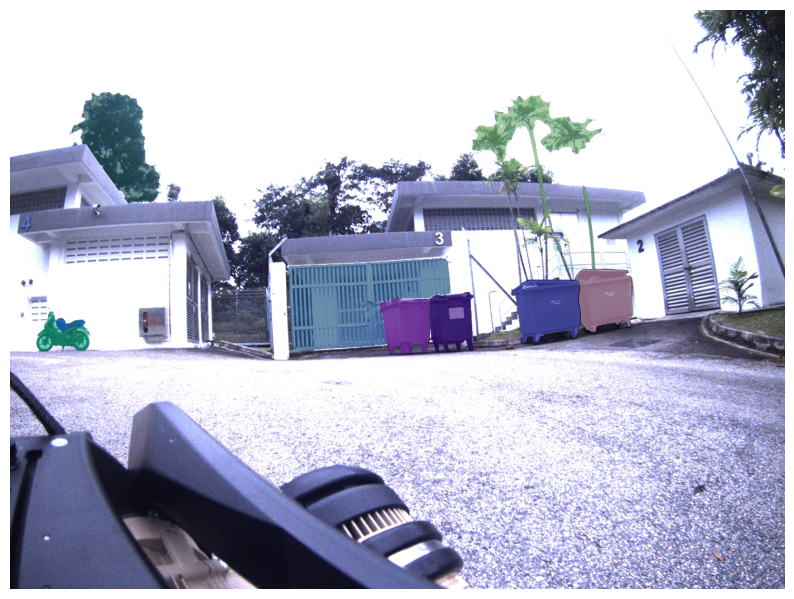

In [ ]:
# compute SAM image embedding
sam_predictor.set_image(image_array)
thing_masks = sam_masks_from_dino_boxes(sam_predictor, image_array, thing_boxes, device)

plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(image)
for thing_mask in thing_masks:
    show_mask(thing_mask.cpu().numpy(), plt.gca(), random_color=True)

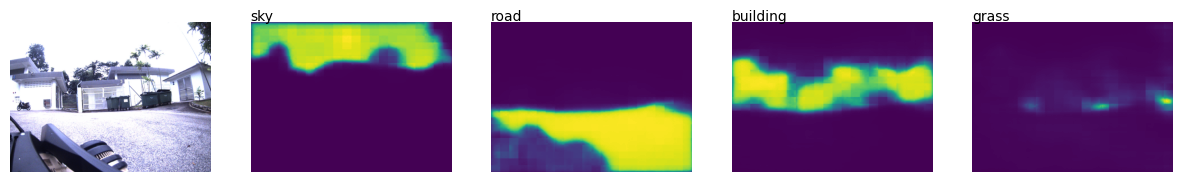

In [ ]:
segmentation_background_threshold = 0.1

# get rough segmentation masks for "stuff" categories using CLIPSeg
clipseg_preds, clipseg_semantic_inds = clipseg_segmentation(
    clipseg_processor,
    clipseg_model,
    image,
    stuff_categories,
    segmentation_background_threshold,
    device,
)
show_segmentation_preds(clipseg_preds, stuff_categories)

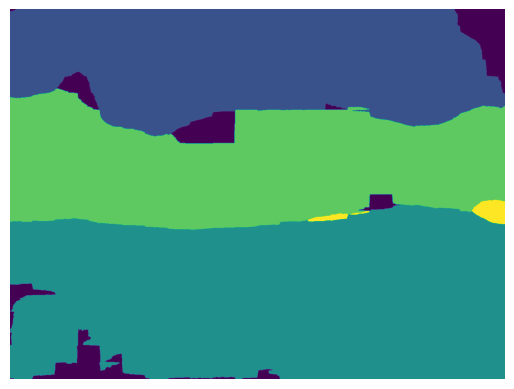

In [ ]:
plt.axis("off")
plt.imshow(clipseg_semantic_inds)

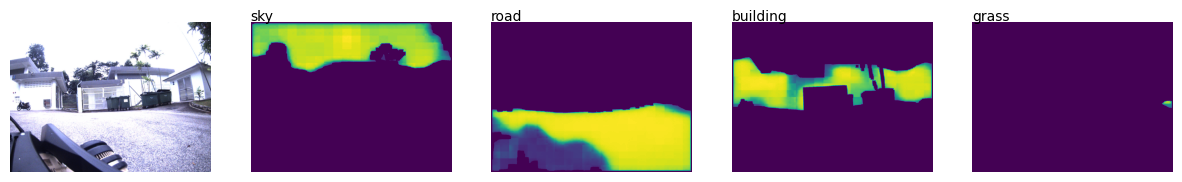

In [ ]:
# remove things from stuff masks
clipseg_semantic_inds_without_things = clipseg_semantic_inds.clone()
if len(thing_boxes > 0):
    combined_things_mask = torch.any(thing_masks, dim=0)
    clipseg_semantic_inds_without_things[combined_things_mask[0]] = 0
# clip CLIPSeg preds based on non-overlapping semantic segmentation inds (+ optionally shrink the mask of each category)
# also returns the relative size of each category
shrink_kernel_size = 20
clipsed_clipped_preds, relative_sizes = clip_and_shrink_preds(
    clipseg_semantic_inds_without_things,
    clipseg_preds,
    shrink_kernel_size,
    len(stuff_categories) + 1,
)
show_segmentation_preds(clipsed_clipped_preds, stuff_categories)